# 4. Phase Equilibria Calculation with the FE-ANN(s) EoS

The FE-ANN(s) EoS can predict the whole phase diagram, including the critical point, triple point, Vapor-Liquid Equilibrium (VLE), Solid-Liquid Equilibrium (SLE), and Solid-Vapor Equilibrium (SVE) of the Mie particle.

$$ \mathcal{U}^{\mathrm{Mie}} = \mathcal{C}^{\mathrm{Mie}} \epsilon \left[ \left(\frac{\sigma}{r}\right)^{\lambda_r} -  \left(\frac{\sigma}{r}\right)^{\lambda_a} \right] $$

First, we need to upload the required packages:
- **numpy**: numerical python
- **matplotlib**: figures in python
- **jax**: high-performance numerical computing and machine learning
- **nest_asyncio**: needed to load the checkpoints
- **feanns_eos**: library with implemented FE-ANN(s) EoS and phase equilibria solvers.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
from jax import numpy as jnp

from feanns_eos import HelmholtzModel
from feanns_eos import load_feanns_params
from feanns_eos import helper_get_alpha
from feanns_eos import helper_solver_funs

from feanns_eos import critical_point_solver, triple_point_solver
from feanns_eos import vle_solver, sle_solver, sve_solver

from jax.config import config
config.update("jax_enable_x64", True)
type_np = np.float64
type_jax = jnp.float64

# needed to read checkpoints in jupyter notebooks
import nest_asyncio
nest_asyncio.apply()

The FE-ANN(s) EoS is loaded as shown in the previous jupyter notebook.

The dictionary `fun_dic` contains compiled functions for the phase equilibria and density solvers.

In [2]:
# directory where checkpoints are saved
ckpt_dir = "./eos_params"
# name of the checkpoint
prefix = "feanns_"

# loading the current checkpoint
state = load_feanns_params(ckpt_dir, prefix=prefix)

# creating the model with the given features
model = HelmholtzModel(features=state['features'])
params = {'params': state['params']}

# needed for phase equilibria solvers
fun_dic = helper_solver_funs(model, params)


The calculations are shown here for $\lambda_r=20$ and $\lambda_a$ (`lr=20` and `la=6`).

Note that the phase equilibria solvers are sensitive to initial guesses. For the case of VLE, SLE, and SVE, the initial guess can be obtained from a previous calculation. 

*Note:* The initial guesses provided here are specific for the pair `lr=20` and `la=6` and might fail for other exponents.  

In [3]:
# getting Mie particle alpha parameter
lr = 20
la = 6
alpha = helper_get_alpha(lr, la)

# range to obtain the phase diagram
Tlower = 0.5
Tupper = 2.

#### Critical Point

The critical point is characterized by the density and temperature conditions that fulfill the following:

$$ \left(\frac{\partial P^*}{\partial \rho^*} \right)_{T^*} = \left(\frac{\partial^2 P^*}{\partial \rho^{*2}} \right)_{T^*} = 0 $$

The critical point is obtained using the `critical_point_solver` function. This function requires the $\alpha_{\mathrm{vdw}}$ parameter and the jitted functions obtained with `helper_solver_fun`. The initial guesses are provided with the `inc0 = [rhoad, Tad]` parameter.

In [4]:
# obtaining critical point
# initial guesses for lr=20, la=6, [rhocad, Tcad]
inc0 = [0.3, 1.3]
critical_point = critical_point_solver(alpha, fun_dic=fun_dic, inc0=inc0, full_output=True)
critical_point

2024-04-01 13:59:35.120346: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none


{'rhocad': 0.322961465652171,
 'Tcad': 1.033302821169252,
 'Pcad': 0.11282474665721455,
 'success': True}

#### Triple Point

At the triple point, three different densities exhibit the same pressure and chemical potential.

$$ P^{*, \mathrm{vap}} = P^{*, \mathrm{liq}} = P^{*, \mathrm{sol}}$$
$$ \mu^{*, \mathrm{vap}} = \mu^{*, \mathrm{liq}} = \mu^{*, \mathrm{sol}}$$

The triple point is obtained using the `triple_point_solver` function. This function requires the $\alpha_{\mathrm{vdw}}$ parameter and the jitted functions obtained with `helper_solver_fun`. The initial guesses are provided with the `inc0=[rhovad, rholad, rhosad, Tad]` parameter.

In [5]:
# obtaining triple point
# initial guesses for lr=20, la=6, [rhovad, rholad, rhosad, Tad]
inc0 = [1e-3, 0.81, 0.99, 0.67] 
triple_point = triple_point_solver(alpha, fun_dic=fun_dic,
                                 inc0=inc0, full_output=True)
triple_point

2024-04-01 13:59:35.208825: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none
2024-04-01 13:59:35.234634: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none
2024-04-01 13:59:35.242429: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none


{'rhovad': 0.008370613714139755,
 'rholad': 0.8235203972322471,
 'rhosad': 0.9948782217833293,
 'Tad': 0.6692705721407431,
 'Pad': 0.0052543629413101915,
 'success': True}

#### Two-phase equilibria

Two phases coexist when they exhibit the same pressure and chemical potential at a given temperature. 

$$ P^{*, \mathrm{I}} = P^{*, \mathrm{II}}$$
$$ \mu^{*, \mathrm{I}} = \mu^{*, \mathrm{II}}$$

These conditions are the principle for computing Vapor-Liquid Equilibria, Solid-Liquid Equilibria, and Solid-Vapor Equilibria.


#### Vapor-Liquid Equilibria

The VLE is computed from the triple point up to the critical point using the `vle_solver` function. This function requires the `alpha` parameter and the temperature. You must provide the jitted functions obtained with `helper_solver_fun` and the critical point (obtained with `critical_point_solver`). 

This function requires an initial guess of the equilibrium pressure `Pad0` or the equilibrium densities `rho0`. You can also provide both of them. 

The calculation can be initialized from the triple-point results. 

In [6]:
# computing VLE from above the triple point up to close the critical point
n_vle = 200
T_vle_model = np.linspace(1.0 * triple_point['Tad'], 0.999*critical_point['Tcad'], n_vle)

rhov_vle_model = np.zeros(n_vle)
rhol_vle_model = np.zeros(n_vle)
Pvle_model = np.zeros(n_vle)

i = 0 
rho0 = [triple_point['rhovad'], triple_point['rholad']] 
sol_vle = vle_solver(alpha, T_vle_model[i], fun_dic=fun_dic, critical=critical_point,
                     rho0=rho0, Pad0=triple_point['Pad'])
Pvle_model[i], rhov_vle_model[i], rhol_vle_model[i] = sol_vle

# computing the rest of the diagram using the previous solution as initial guess
for i in range(1, n_vle):
    rho0=[rhov_vle_model[i-1], rhol_vle_model[i-1]] 
    sol_vle = vle_solver(alpha, T_vle_model[i], Pad0=Pvle_model[i-1], fun_dic=fun_dic, 
                         critical=critical_point, rho0=rho0,
                         good_initial=True)
    Pvle_model[i], rhov_vle_model[i], rhol_vle_model[i] = sol_vle

2024-04-01 13:59:35.383018: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none
2024-04-01 13:59:35.726871: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none


#### Solid-Liquid Equilibria

The SLE is computed from the triple point using the `sle_solver` function.  This function requires the `alpha` parameter and the temperature. You must provide the jitted functions obtained with `helper_solver_fun`.

This function also requires an initial guess for the equilibrium densities `rho0`.

The calculation can be initialized from the triple point results. 

In [7]:
# computing SLE from above the triple point up to Tupper
n_sle = 100
T_sle_model = np.linspace(1.0 * triple_point['Tad'], Tupper, n_sle)

rhos_sle_model = np.zeros(n_sle)
rhol_sle_model = np.zeros(n_sle)
Psle_model = np.zeros(n_sle)

i = 0
# using triple point as initial guess
rho0 = [triple_point['rholad'], triple_point['rhosad']]
sol_sle = sle_solver(alpha, T_sle_model[i], fun_dic=fun_dic, rho0=rho0)
Psle_model[i] = sol_sle[0]
rhol_sle_model[i] = sol_sle[1]
rhos_sle_model[i] = sol_sle[2]

for i in range(1, n_sle):
    # using  previous solution as initial guesses
    rho0 = [rhol_sle_model[i-1], rhos_sle_model[i-1]]
    sol_sle = sle_solver(alpha, T_sle_model[i], fun_dic=fun_dic, rho0=rho0)
    Psle_model[i] = sol_sle[0]
    rhol_sle_model[i] = sol_sle[1]
    rhos_sle_model[i] = sol_sle[2]

#### Solid-Vapor Equilibria

The SVE is computed from the triple point using the `sve_solver` function.  This function requires the `alpha` parameter and the temperature. You must provide the jitted functions obtained with `helper_solver_fun`.

This function also requires an initial guess for the equilibrium densities `rho0`.

The calculation can be initialized from the triple point results. 

In [8]:
# computing SVE from above the triple point up to Tlower
n_sve = 20
T_sve_model = np.linspace(1.0 * triple_point['Tad'], Tlower, n_sve)

rhov_sve_model = np.zeros(n_sve)
rhos_sve_model = np.zeros(n_sve)
Psve_model = np.zeros(n_sve)

i = 0
# using triple point as initial guess
rho0 = [triple_point['rhovad'], triple_point['rhosad']]
sol_sve = sve_solver(alpha, T_sle_model[i], fun_dic=fun_dic, rho0=rho0)
Psve_model[i] = sol_sve[0]
rhov_sve_model[i] = sol_sve[1]
rhos_sve_model[i] = sol_sve[2]

for i in range(1, n_sve):
    # using  previous solution as initial guesses
    rho0 = [rhov_sve_model[i-1], rhos_sve_model[i-1]]
    sol_sve = sve_solver(alpha, T_sve_model[i], fun_dic=fun_dic, rho0=rho0)
    Psve_model[i] = sol_sve[0]
    rhov_sve_model[i] = sol_sve[1]
    rhos_sve_model[i] = sol_sve[2]

#### Plotting the whole phase diagram


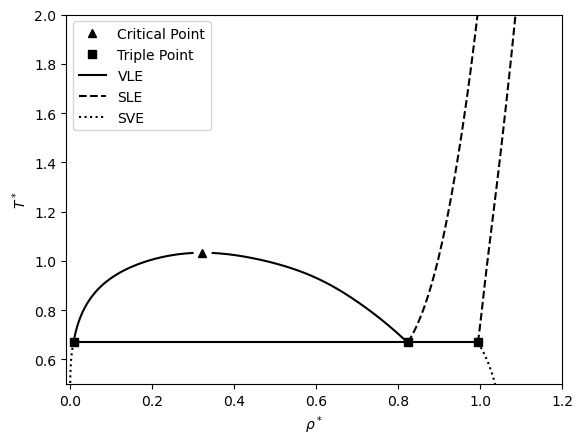

In [9]:
# plotting critical point
plt.plot(critical_point['rhocad'], critical_point['Tcad'], '^', color='k', label='Critical Point')
# plotting triple point
plt.plot([triple_point['rhovad'], triple_point['rholad'], triple_point['rhosad']],
         [triple_point['Tad'], triple_point['Tad'], triple_point['Tad']],
         's', color='k', label='Triple Point')
plt.plot([triple_point['rhovad'], triple_point['rholad'], triple_point['rhosad']],
         [triple_point['Tad'], triple_point['Tad'], triple_point['Tad']],
         '-', color='k')
# plotting VLE
plt.plot(rhov_vle_model, T_vle_model, color='k', label='VLE')
plt.plot(rhol_vle_model, T_vle_model, color='k')

# plotting SLE
plt.plot(rhol_sle_model, T_sle_model, '--', color='k', label='SLE')
plt.plot(rhos_sle_model, T_sle_model, '--', color='k')

# plotting SVE
plt.plot(rhov_sve_model, T_sve_model, ':', color='k', label='SVE')
plt.plot(rhos_sve_model, T_sve_model, ':', color='k')

plt.xlim([-1e-2, 1.2])
plt.ylim([Tlower, Tupper])

plt.xlabel(r'$\rho^*$')
plt.ylabel(r'$T^*$')
plt.legend()

#### Plotting the Clapyeron diagram

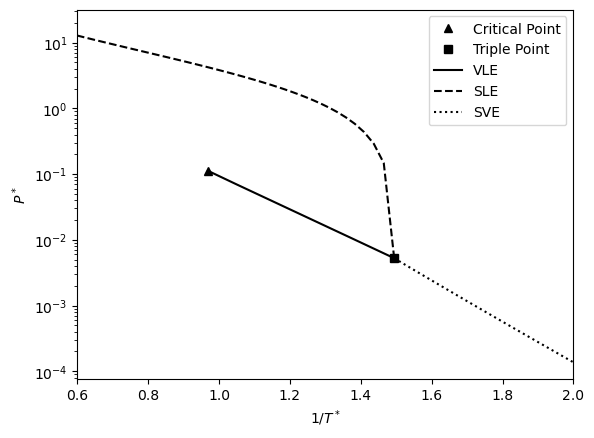

In [10]:
# plotting critical point
plt.plot(1/critical_point['Tcad'], critical_point['Pcad'], '^', color='k', label='Critical Point')

# plotting triple point
plt.plot(1/triple_point['Tad'], triple_point['Pad'], 's', color='k', label='Triple Point')

# plotting VLE, SLE, SVE
plt.plot(1./T_vle_model, Pvle_model, color='k', label='VLE')
plt.plot(1./T_sle_model, Psle_model, '--', color='k', label='SLE')
plt.plot(1./T_sve_model, Psve_model, ':', color='k', label='SVE')

plt.yscale('log')

plt.xlabel(r'$1/T^*$')
plt.ylabel(r'$P^*$')
plt.xlim([0.6, 2.0])
plt.legend()

Additionally, you can obtain other saturation properties, such as the enthalpy of a phase change.

In [11]:
# compiling the residual enthalpy function
enthalpy_residual_fun = jax.jit(lambda alpha, rhoad, Tad:
                                model.enthalpy_residual(params,
                                                        jnp.atleast_1d(alpha),
                                                        jnp.atleast_1d(rhoad),
                                                        jnp.atleast_1d(Tad)))

# computing vaporization enthalpy
alpha_vle = alpha * np.ones(n_vle)
hresv = enthalpy_residual_fun(alpha_vle, rhov_vle_model, T_vle_model)
hresl = enthalpy_residual_fun(alpha_vle, rhol_vle_model, T_vle_model)
dHvap = hresv - hresl

# computing melting enthalpy
alpha_sle = alpha * np.ones(n_sle)
hresl = enthalpy_residual_fun(alpha_sle, rhol_sle_model, T_sle_model)
hress = enthalpy_residual_fun(alpha_sle, rhos_sle_model, T_sle_model)
dHmelting = hresl - hress

# computing sublimation enthalpy
alpha_sve = alpha * np.ones(n_sve)
hresv = enthalpy_residual_fun(alpha_sve, rhov_sve_model, T_sve_model)
hress = enthalpy_residual_fun(alpha_sve, rhos_sve_model, T_sve_model)
dHsublimation = hresv - hress

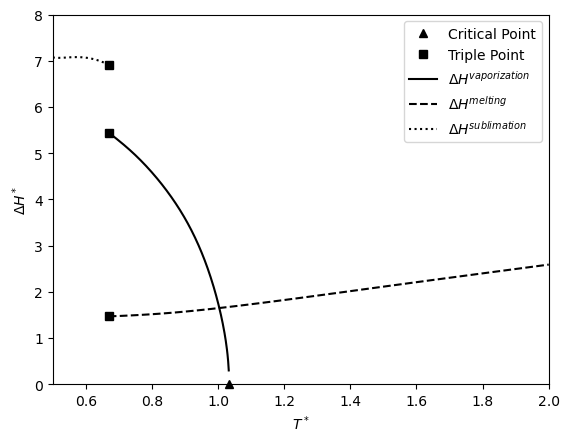

In [12]:
plt.plot(critical_point['Tcad'], 0.0, '^', color='k', label=r'Critical Point', clip_on=False)
plt.plot(3 * [triple_point['Tad']], [dHmelting[0], dHvap[0], dHsublimation[0]], 
         's', color='k', label=r'Triple Point', clip_on=False)

plt.plot(T_vle_model, dHvap, color='k', label=r'$\Delta H^{vaporization}$')
plt.plot(T_sle_model, dHmelting, '--', color='k', label=r'$\Delta H^{melting}$')
plt.plot(T_sve_model, dHsublimation, ':', color='k', label=r'$\Delta H^{sublimation}$')

plt.xlim([Tlower, Tupper])
plt.ylim([0.0, 8.])

plt.xlabel(r'$T^*$')
plt.ylabel(r'$\Delta H^*$')
plt.legend()